# Vortex Panel Method - Airfoils

This code is intended to calculate the effect of general airfoils by using the vortex panel method (VPM) using both constant and linearly varying vortex strengths on each panel.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

### Creating the Airfoil

In [2]:
# Input data
airfoil_check = False  # var to check airfoil panels
airfoil_type  = 3      # 1: NACA 4 digits, 2: NACA 5 digits, 3: from excel
plot_stream   = True   # whether to plot stream lines around the airfoil
aero_center   = 0      # optimization to calculate the aerodynamic center

# Airfoil data
airfoil_name  = '43040'    # airfoil nomenclature
spacing       = 'cosine'  # 1: 'linear' or 'cosine' as a spacing type
N             = 40        # number of boundary points, N panels = N - 1
blunt_TE      = False     # whether the TE is blunt (True) or sharp (False)

In [3]:
# Run conditions
AoA_init  = 10.0
AoA_final = 10.0
AoA_delta = 1
AoA       = np.linspace(AoA_init, AoA_final, AoA_delta)

U_inf     = 1.0   # Uniform flow velocity

### NACA 4-digits

$y_{c} =
\begin{cases}
\frac{m}{p^2} (2px - x^2), & 0 \leq x < p\\
\frac{m}{(1-p)^2} ((1-2p) + 2px - x^2), & p \leq x \leq 1
\end{cases}
$

where <br>
$m$ is the maximum camber (100 $m$ is the first of of the four digits), <br>
$p$ is the location of maximum camber (10 $p$ is the second digit in the NACA xxxx description). <br>
For example, a NACA 2412 airfoil uses 2% camber (first digit), 40% along the chord and a 0012 symmetrical airfoil having a thickness 12% (third and fourth digits) of the chord. <br>
For this cambered airfoil, because the thickness needs to be applied perpendicular to the camber line, the coordinates $(xu, yu)$ and $(xl, yl)$ of respectively the upper and lower airfoil surface, become <br>

$x_{U} = x - y_{t} \sin \theta, \quad y_{U} = y_{c} + y_{t} \cos \theta \\
x_{L} = x + y_{t} \sin \theta, \quad y_{L} = y_{c} - y_{t} \cos \theta,$

where <br>
$\theta = \arctan \frac{dy_{c}}{dx},\\
\frac{dy_{c}}{dx} = 
\begin{cases}
\frac{2m}{p^2} (p-x), & 0 \leq x \leq p \\
\frac{2m}{(1-p)^2} (p-x), & p \leq x \leq 1
\end{cases} \\
y_{t} = 5t[0.2969 \sqrt{x} - 0.1260x - 0.3516x^2 + 0.2843x^3 - 0.1015x^4]
$


In [4]:
def naca4(name, N, spacing, blunt_TE):
    """
    Calculates a NACA 4-digit airfoil coordinate
        name    : airfoil name based on the 4-digit nomenclature
        N       : number of grid points
        spacing : either 'linear' or 'cosine'
        blunt_TE: whether the TE is blunt (True) or sharp (False)
    """
    N = int(N/2)
    # NACA 4-digit
    m = eval(name[0])  # camber
    p = eval(name[1])  # position of max camber
    t = eval(name[2:]) # thickness
    
    # Constants of NACA 4-digit
    a0 = 0.2969
    a1 = -0.1260
    a2 = -0.3516
    a3 = 0.2843
    if blunt_TE:
        a4 = -0.1015 # blunt TE
    else:
        a4 = -0.1036 # sharp TE
    
    # Airfoil creation
    # percentage
    M = m/100
    P = p/10
    T = t/100
    
    # Airfoil grid
    if spacing == 'linear':
        x = np.linspace(0,1,N)
    elif spacing == 'cosine':
        bet = np.linspace(0,np.pi,N)
        x = 0.5*(1-np.cos(bet))
    
    # Camber and gradient
    yc    = np.zeros(N)
    dyc   = np.zeros(N)
    theta = np.zeros(N)
    
    for i in range(N):
        if x[i] >= 0 and x[i] < P:
            yc[i]  = (M/(P*P))*(2*P*x[i] - x[i]*x[i])
            dyc[i] = (2*M/(P*P))*(P - x[i]) 
        elif x[i] >= P and x[i] <= 1:
            yc[i]  = (M/(1-P)**2)*((1-2*P) + 2*P*x[i] - x[i]*x[i])
            dyc[i] = (2*M/(1-P)**2)*(P - x[i])
        theta[i] = np.arctan(dyc[i])
    
    # Thickness distribution
    yt = np.zeros(N)
    for i in range(N):
        yt[i] = 5*T*(a0*np.sqrt(x[i]) + a1*x[i] + a2*x[i]**2 + a3*x[i]**3 + a4*x[i]**4)

    # Upper surface points
    xu = np.zeros((N,1))
    yu = np.zeros((N,1))
    for i in range(N):
        xu[i,0] = x[i]  - yt[i] * np.sin(theta[i])
        yu[i,0] = yc[i] + yt[i] * np.cos(theta[i])
        
    # Lower surface points
    xl = np.zeros((N,1))
    yl = np.zeros((N,1))
    for i in range(N):
        xl[i,0] = x[i]  + yt[i] * np.sin(theta[i])
        yl[i,0] = yc[i] - yt[i] * np.cos(theta[i])
        
    upper_coordinates = np.concatenate((xu,yu),axis=1)
    lower_coordinates = np.concatenate((xl,yl),axis=1)
    coordinates       = np.concatenate((upper_coordinates,lower_coordinates),axis=0)
    
    return coordinates

### NACA 5-digit airfoils

The NACA 5-digit airfoils use the same thickness envelope as the 4-series but with a different camber line and numbering system. <br><br>
<center><strong>NACA LPQXX</strong>
<br>
e.g.,<br>
<strong>NACA 23012</strong></center>
<table>
    <thead>
        <tr>
            <th style="text-align: left"> Digits </th>
            <th style="text-align: left"> Letter </th>
            <th style="text-align: left"> Example </th>
            <th style="text-align: left"> Description </th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: center"> 1 </td>
            <td style="text-align: center"> L </td>
            <td style="text-align: center"> 2 </td>
            <td style="text-align: left"> This digit controls the camber. It indicates the designed coefficient of lift (Cl) multiplied by 3/20. In the example, $L = 2$, so $C_{L} = 0.3$</td>
        </tr>
        <tr>
            <td style="text-align: center"> 2 </td>
            <td style="text-align: center"> P </td>
            <td style="text-align: center"> 3 </td>
            <td style="text-align: left"> The position of maximum camber divided by 20. In the example, $P=3$, so maximum camber is at 0.15 or 15% chord. </td>
        </tr>
        <tr>
            <td style="text-align: center"> 3 </td>
            <td style="text-align: center"> Q </td>
            <td style="text-align: center"> 0 </td>
            <td style="text-align: left"> 0 = normal camber line, 1 = reflex camber line </td>
        </tr>
        <tr>
            <td style="text-align: center"> 4 & 5</td>
            <td style="text-align: center"> XX </td>
            <td style="text-align: center"> 12 </td>
            <td style="text-align: left"> The maximum thickness as percentage. In the example, $XX = 12$, so the maximum thickness is 0.12 or 12% chord.</td>
        </tr>
    </tbody>
</table>

The equation for the camber line is split into two sections like the 4 digit series but the division between the two sections is not at the point of maximum camber. There are also different equations for standard and reflex camber lines.

<table>
    <tr>
        <th style="text-align: left; width:10%">  </th>
        <th style="text-align: left; width:30%"> Front $(0 \leq x < r)$</th>
        <th style="text-align: left"> Back $(r \leq x \leq 1)$ </th>
    </tr>
    <tr>
        <td style="text-align: center"> Camber (standard) </td>
        <td style="text-align: left"> $y_{c} = \frac{k_{1}}{6}\big(x^3 - 3rx^2 + r^2(3-r)x\big)$ </td>
        <td style="text-align: left"> $y_{c} = \frac{k_{1}r^3}{6}(1-x)$ </td>
    </tr>
    <tr>
        <td style="text-align: center"> Gradient (standard) </td>
        <td style="text-align: left"> $y_{c} = \frac{dy_{c}}{dx} = \frac{k_{1}}{6} \big(3x^2 - 6rx + r^2(3-r)\big)$ </td>
        <td style="text-align: left"> $\frac{dy_{c}}{dx} = \frac{-k_{1}r^3}{6}$ </td>
    </tr>
    <tr>
        <td style="text-align: center"> Camber (reflex) </td>
        <td style="text-align: left"> $y_{c} = \frac{k_{1}}{6}\big((x-r)^3 - \frac{k_{2}}{k_{1}}(1-r)^3x - r^3x + r^3\big)$ </td>
        <td style="text-align: left"> $y_{c} = \frac{k_{1}}{6}\big(\frac{k_{2}}{k_{1}}(x-r)^3 - \frac{k_{2}}{k_{1}}(1-r)^3x - r^3x + r^3\big)$ </td>
    </tr>
    <tr>
        <td style="text-align: center"> Gradient (reflex) </td>
        <td style="text-align: left"> $y_{c} = \frac{dy_{c}}{dx} = \frac{k_{1}}{6} \big(3(x-r)^2 -\frac{k_{2}}{k_{1}}(1-r)^3 - r^3\big)$ </td>
        <td style="text-align: left"> $\frac{dy_{c}}{dx} = \frac{k_{1}}{6} \big(3\frac{k_{2}}{k_{1}}(x-r)^2 - \frac{k_{2}}{k_{1}}(1-r)^3 - r^3 \big)$ </td>
    </tr>
</table>
<br>
The values for the constants $r$, $k_{1}$, and $k_{2}/k_{1}$ are tabulated for various positions of the maximum camber at a coefficient of lift ($C_{L}$) value of 0.3. The camber and gradient can be scaled linearly to the required $C_{L}$ value.
<table>
    <thead>
        <tr>
            <th style="text-align: center"> Description </th>
            <th style="text-align: center"> Digits </th>
            <th style="text-align: center"> Camber position (%) </th>
            <th style="text-align: center"> $r$ </th>
            <th style="text-align: center"> $k_{1} $ </th>
            <th style="text-align: center"> $k_{2}/k_{1}$ </th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: center"> 5% standard </td>
            <td style="text-align: center"> 10 </td>
            <td style="text-align: center"> 5 </td>
            <td style="text-align: center"> 0.0580 </td>
            <td style="text-align: center"> 361.400 </td>
            <td style="text-align: center">  </td>
        </tr>
        <tr>
            <td style="text-align: center"> 10% standard </td>
            <td style="text-align: center"> 20 </td>
            <td style="text-align: center"> 10 </td>
            <td style="text-align: center"> 0.1260 </td>
            <td style="text-align: center"> 51.640 </td>
            <td style="text-align: center">  </td>
        </tr>
        <tr>
            <td style="text-align: center"> 15% standard </td>
            <td style="text-align: center"> 30 </td>
            <td style="text-align: center"> 15 </td>
            <td style="text-align: center"> 0.2025 </td>
            <td style="text-align: center"> 15.957 </td>
            <td style="text-align: center">  </td>
        </tr>
        <tr>
            <td style="text-align: center"> 20% standard </td>
            <td style="text-align: center"> 40 </td>
            <td style="text-align: center"> 20 </td>
            <td style="text-align: center"> 0.2900 </td>
            <td style="text-align: center"> 6.643 </td>
            <td style="text-align: center">  </td>
        </tr>
        <tr>
            <td style="text-align: center"> 25% standard </td>
            <td style="text-align: center"> 50 </td>
            <td style="text-align: center"> 25 </td>
            <td style="text-align: center"> 0.3910 </td>
            <td style="text-align: center"> 3.230 </td>
            <td style="text-align: center">  </td>
        </tr>
        <tr>
            <td style="text-align: center"> 10% reflex </td>
            <td style="text-align: center"> 21 </td>
            <td style="text-align: center"> 10 </td>
            <td style="text-align: center"> 0.1300 </td>
            <td style="text-align: center"> 51.990 </td>
            <td style="text-align: center"> 0.000764 </td>
        </tr>
        <tr>
            <td style="text-align: center"> 15% reflex </td>
            <td style="text-align: center"> 31 </td>
            <td style="text-align: center"> 15 </td>
            <td style="text-align: center"> 0.2170 </td>
            <td style="text-align: center"> 15.793 </td>
            <td style="text-align: center"> 0.00677 </td>
        </tr>
        <tr>
            <td style="text-align: center"> 20% reflex </td>
            <td style="text-align: center"> 41 </td>
            <td style="text-align: center"> 20 </td>
            <td style="text-align: center"> 0.3180 </td>
            <td style="text-align: center"> 6.520 </td>
            <td style="text-align: center"> 0.0303 </td>
        </tr>
        <tr>
            <td style="text-align: center"> 25% reflex </td>
            <td style="text-align: center"> 51 </td>
            <td style="text-align: center"> 25 </td>
            <td style="text-align: center"> 0.4410 </td>
            <td style="text-align: center"> 3.191 </td>
            <td style="text-align: center"> 0.1355 </td>
        </tr>
    </tbody>
</table>
<br>
Having calculated the camber line, the thickness distribution, calculation of the airfoil envelope and plotting of coordinates is done in the same way as the NACA 4-digit airfoils. Details can be found in <a href="http://www.dept.aoe.vt.edu/~mason/Mason_f/CAtxtAppA.pdf">here</a>.

In [5]:
def naca5(name, N, spacing, blunt_TE):
    """
    Calculates a the NACA 5-digit airfoil
        name    : airfoil name based on the 5-digit nomenclature
        N       : number of grid points
        spacing : either 'linear' or 'cosine'
        blunt_TE: whether the TE is blunt (True) or sharp (False)
    """
    N = int(N/2)
    # NACA 5-digit
    L  = eval(name[0]) * 3/20  # This digit controls the camber
    P  = eval(name[1]) / 20    # The position of max camber divided by 20
    Q  = eval(name[2])         # 0: normal camber line, 1: reflex camber line
    XX = eval(name[3:])        # The max thickness as percentage.
    
    # Constants of NACA 5-digit airfoils
    # Thickness
    a0 = 0.2969
    a1 = -0.1260
    a2 = -0.3516
    a3 = 0.2843
    if blunt_TE:
        a4 = -0.1015 # blunt TE
    else:
        a4 = -0.1036 # sharp TE
    # Camber
    if Q == 0:
        DATA = np.array([[10, 0.0580, 361.40],
                         [20, 0.1260, 51.640],
                         [30, 0.2025, 15.957],
                         [40, 0.2900, 6.6430],
                         [50, 0.3910, 3.2300]])
    else:
        DATA = np.array([[21, 0.130, 51.990, 0.000764],
                         [31, 0.217, 15.793, 0.006770],
                         [41, 0.318, 6.5200, 0.030300],
                         [51, 0.441, 3.1910, 0.135500]])
    
    # Airfoil creation
    NUMB = eval(name[1:3]) # get digit value for interpolation
    
    f_r  = interp1d(DATA[:,0],DATA[:,1])
    r    = f_r(NUMB)
    f_k1 = interp1d(DATA[:,0],DATA[:,2])
    k1   = f_k1(NUMB)*(L/0.3)
    if Q == 1:
        f_k2k1 = interp1d(DATA[:,0],DATA[:,3])
        k2k1   = f_k2k1(NUMB)
        
    # Airfoil grid
    if spacing == 'linear':
        x = np.linspace(0,1,N)
    elif spacing == 'cosine':
        bet = np.linspace(0,np.pi,N)
        x = 0.5*(1-np.cos(bet))
    
    # Camber and gradient
    yc    = np.zeros(N)
    dyc   = np.zeros(N)
    theta = np.zeros(N)
    
    if Q == 0:
        for i in range(N):
            if x[i] >= 0 and x[i] < r:
                yc[i]  = (k1/6) * (x[i]**3 - 3*r*x[i]**2 + r*r*(3-r)*x[i])
                dyc[i] = (k1/6) * (3*x[i]**2 - 6*r*x[i] + r*r*(3-r))
            else:
                yc[i]  = ((k1*r**3)/(6)) * (1 - x[i])
                dyc[i] = -(k1*r**3)/6
            theta[i] = np.arctan(dyc[i])
    else:
        for i in range(N):
            if x[i] >= 0 and x[i] < r:
                yc[i]  = (k1/6) * ( (x[i] - r)**3 - k2k1*x[i]*(1-r)**3 - x[i]*r**3 + r**3 )
                dyc[i] = (k1/6) * ( 3*(x[i] - r)**2 - k2k1*(1-r)**3 - r**3 )
            else:
                yc[i]  = (k1/6) * ( k2k1*(x[i] - r)**3 - k2k1*x[i]*(1-r)**3 - x[i]*r**3 + r**3 )
                dyc[i] = (k1/6) * ( 3*k2k1*(x[i] - r)**2 - k2k1*(1-r)**3 - r**3 )
            theta[i] = np.arctan(dyc[i])
    
    # Thickness distribution
    yt = np.zeros(N)
    T  = XX/100 
    for i in range(N):
        yt[i] = 5*T*(a0*np.sqrt(x[i]) + a1*x[i] + a2*x[i]**2 + a3*x[i]**3 + a4*x[i]**4)
    
    # Upper surface points
    xu = np.zeros((N,1))
    yu = np.zeros((N,1))
    for i in range(N):
        xu[i,0] = x[i]  - yt[i] * np.sin(theta[i])
        yu[i,0] = yc[i] + yt[i] * np.cos(theta[i])
        
    # Lower surface points
    xl = np.zeros((N,1))
    yl = np.zeros((N,1))
    for i in range(N):
        xl[i,0] = x[i]  + yt[i] * np.sin(theta[i])
        yl[i,0] = yc[i] - yt[i] * np.cos(theta[i])
    
    upper_coordinates = np.concatenate((xu,yu),axis=1)
    lower_coordinates = np.concatenate((xl,yl),axis=1)
    coordinates       = np.concatenate((upper_coordinates,lower_coordinates),axis=0)
    
    return coordinates

In [7]:
if airfoil_type == 1:
    coord = naca4(airfoil_name, N, spacing, blunt_TE)
    
elif airfoil_type == 2:
    coord = naca5(airfoil_name, N, spacing, blunt_TE)

elif airfoil_type == 3: # read csv file
#     coord_df = pd.read_excel("geom/cylinder.xlsx")
    coord_df = pd.read_excel("geom/NACA63212.xlsx")  
#     airfoil_name = "cylinder"
    airfoil_name = "NACA-63212"
    coord = coord_df.to_numpy()
    coord_up = np.concatenate((coord[:,0].reshape(-1,1),coord[:,1].reshape(-1,1)),axis=1)
    coord_lo = np.concatenate((coord[:,2].reshape(-1,1),coord[:,3].reshape(-1,1)),axis=1)
    coord = np.concatenate((coord_up,coord_lo),axis=0)

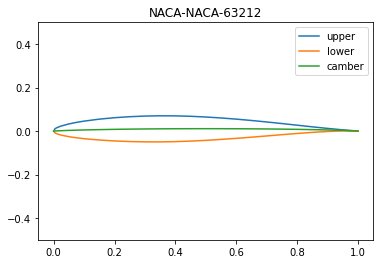

In [8]:
# Visualization
Nh = int(len(coord)/2) # N_half
plt.plot(coord[0:Nh,0],coord[0:Nh,1], label="upper") # upper surface
plt.plot(coord[Nh:,0],coord[Nh:,1], label="lower")   # lower surface
plt.plot(0.5*(coord[0:Nh,0]+coord[Nh:,0]),0.5*(coord[0:Nh,1]+coord[Nh:,1]), label="camber")   # camber line
plt.legend(loc="upper right")
if airfoil_type == 1 or 2:
    plt.title(f"NACA-{airfoil_name}")
else:
    plt.title(f"{airfoil_name}")
plt.ylim([-0.5, 0.5])
plt.show()